# All-in-one Project Notebook

This one is in Keras.

Tasks
Next up:
- be able to run multiple experiments in parallel, and review results on W&B
    - need a training script that loads data, model, hyperparams from the commandline, and runs training, then testing, outputting the final test as last stdout line
    - need a utility function to output a file of such experiment commands
    - need to dynamically allocate GPUs (let's use the redis-based approach we wrote)

- [ ] add code to output training time, gpu utilization, and inference time
    - [x] be able to log GPU utilization
- [ ] add type hints to all methods and move them to own files
- [ ] add another layer of timedistributed dense
- [ ] make a util method for testing and outputting timing
- [-] implement own loss function that ignores the padding character

Meta-tasks
- [ ] be able to collapse notebook sections

In [4]:
GPU_IND = 3

import os
os.environ["CUDA_VISIBLE_DEVICES"] = f'{GPU_IND}'

from collections import defaultdict
import itertools
import random
import re
import string
import time

import gpustat
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.datasets import mnist
from tensorflow.python.keras.models import Model, Sequential
from tensorflow.python.keras.layers import Activation, Conv2D, Dense, Dropout, Input, Flatten, Lambda, MaxPooling2D, Permute, Reshape, TimeDistributed
from tensorflow.python.keras.utils import to_categorical

import util
import datasets
%load_ext autoreload
%autoreload 2

%matplotlib inline

ModuleNotFoundError: No module named 'gpustat'

In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16964841586776819204
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 10913166132
locality {
  bus_id: 1
  links {
  }
}
incarnation: 16840971814238926136
physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:0a:00.0, compute capability: 6.1"
]


In [9]:
gpu_info = gpustat.GPUStatCollection.new_query()[3]
gpu_info.index > 2

True

## Convnet on EMNIST

### Load EMNIST

In [14]:
emnist = datasets.EmnistDataset()
emnist

EMNIST
Num classes: 65
Train: (697932, 784) (697932, 65)
Test: (116323, 784) (116323, 65)

### Train MLP on EMNIST

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_40 (Dense)             (None, 512)               401920    
_________________________________________________________________
dropout_27 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_41 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_28 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_42 (Dense)             (None, 65)                33345     
Total params: 697,921
Trainable params: 697,921
Non-trainable params: 0
_________________________________________________________________
Train on 523449 samples, validate on 174483 samples
Epoch 1/3
523449/523449 [==============================] - 19s 36us/step - loss: 0.7

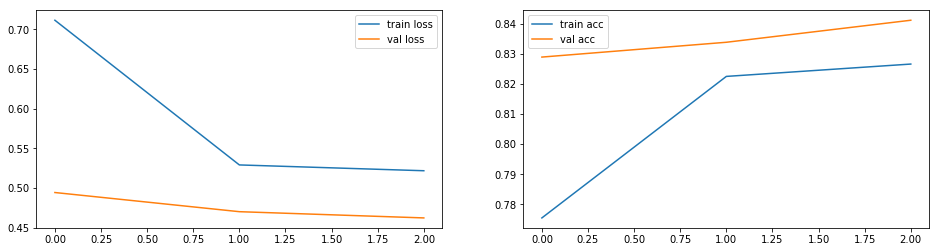

In [26]:
model = create_fc_model(num_classes)
util.train_model(
    model=model,
    x_train=x_train,
    y_train=y_train_categorical,
    loss='categorical_crossentropy',
    epochs=3,
    batch_size=256,
    gpu_ind=GPU_IND
)
score = model.evaluate(x_test, y_test_categorical, verbose=0)
print('Test loss/accuracy:', score[0], score[1])

### Train a classic convnet on EMNIST

In [27]:
def create_lenet_model(num_classes: int) -> Model:
    model = Sequential()
    model.add(Reshape((28, 28, 1), input_shape=(784,)))
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    model.summary()
    return model

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_4 (Reshape)          (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_35 (Dropout)         (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_49 (Dense)             (None, 128)               1179776   
__________

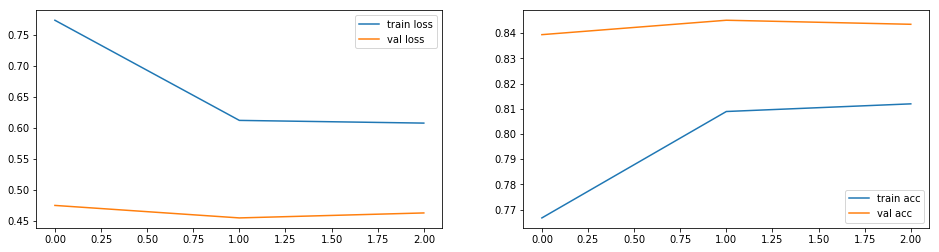

In [31]:
model = create_lenet_model(num_classes)
import wandb
wandb.init(config={'test_key': 'test_val'})

util.train_model(
    model=model,
    x_train=x_train,
    y_train=y_train_categorical,
    loss='categorical_crossentropy',
    epochs=3,
    batch_size=128,
    gpu_ind=GPU_IND
)
score = model.evaluate(x_test, y_test_categorical, verbose=0)
print('Test loss/accuracy:', score[0], score[1])

## String together words

In [46]:
def samples_by_char(samples, labels):
    samples_by_char = defaultdict(list)
    for sample, label in zip(samples, labels.flatten()):
        samples_by_char[mapping[label]].append(sample)
    return samples_by_char

In [47]:
samples_by_char_train = samples_by_char(x_train, y_train)
samples_by_char_test = samples_by_char(x_test, y_test)

In [48]:
def select_letter_samples_for_string(string, samples_by_char):
    zeros = np.zeros((28, 28), 'float32')
    sampled_images = []
    for char in string:
        samples = samples_by_char[char]
        sample = samples[np.random.choice(len(samples))] if len(samples) > 0 else zeros
        sampled_images.append(sample.reshape(28, 28).T)
    return sampled_images
        
def construct_image_from_string(string, samples_by_char, overlap=0):
    assert overlap >= 0 and overlap <= 1
    sampled_images = select_letter_samples_for_string(string, samples_by_char)
    N = len(sampled_images)
    H, W = sampled_images[0].shape
    oW = int(overlap * W)
    noW = W - oW
    new_W = W * N - oW * (N - 1)
    concatenated_image = np.zeros((H, new_W), 'float32')
    x = 0
    for image in sampled_images:
        concatenated_image[:, x:(x + W)] += image
        x += noW
    return np.minimum(1, concatenated_image)

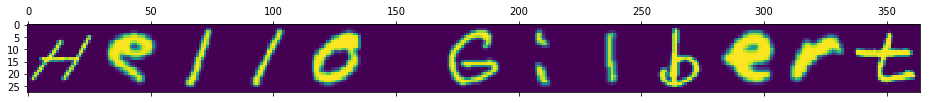

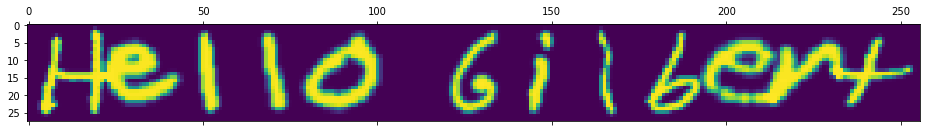

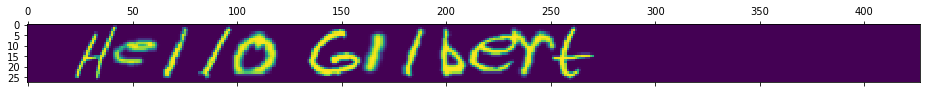

In [49]:
plt.matshow(construct_image_from_string('Hello Gilbert', samples_by_char_train, overlap=0))
plt.matshow(construct_image_from_string('Hello Gilbert', samples_by_char_test, overlap=0.33))
plt.matshow(construct_image_from_string('_Hello Gilbert________', samples_by_char_test, overlap=0.33))

## Get it to work on sequences of fixed length

To get it to work on sequences of fixed length and overlap, we need to time-distribute the convnet over windows of the image, and write a custom loss function that sums the loss of each letter.

In [51]:
def brown_text():
    """Return a single string with the Brown corpus with all punctuation stripped."""
    text = ' '.join(itertools.chain.from_iterable(nltk.corpus.brown.sents()))
    text = text.translate({ord(c): None for c in string.punctuation})
    text = re.sub('  +', ' ', text)
    return text


class SentenceGenerator(object):
    """
    Sample a string from text of the Brown corpus of length at least one word and at most max_length,
    padding it to max_length with the '_' character.
    """
    def __init__(self, max_length: int):
        self.text = brown_text()
        self.word_start_inds = [0] + [_.start(0) + 1 for _ in re.finditer(' ', self.text)]
        self.max_length = max_length
        
    def generate(self) -> str:
        ind = np.random.randint(0, len(self.word_start_inds) - 1)
        start_ind = self.word_start_inds[ind]
        end_ind_candidates = []
        for ind in range(ind + 1, len(self.word_start_inds)):
            if self.word_start_inds[ind] - start_ind > self.max_length:
                break
            end_ind_candidates.append(self.word_start_inds[ind])
        end_ind = np.random.choice(end_ind_candidates)
        sampled_text = self.text[start_ind:end_ind].strip()
        padding = '_' * (self.max_length - len(sampled_text))
        return sampled_text + padding

    
generator = SentenceGenerator(32)
for i in range(20):
    print(generator.generate())
%timeit generator.generate()

and_____________________________
harmonious or inharmonious to___
knowledge of a trade of which___
What you dont understand________
Census the annual_______________
bridegroom in the_______________
this music seriously The________
Af______________________________
the University of Toronto This__
continuing______________________
discreetly in___________________
In the next few_________________
the_____________________________
so extremely____________________
Along with a director the_______
for Arnolphe comes______________
operation requires______________
compelled to____________________
10 M diameter fibers____________
lifted the surprised turtle and_
6.97 µs ± 23.7 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


ultimately eliminated___________
(28, 896)


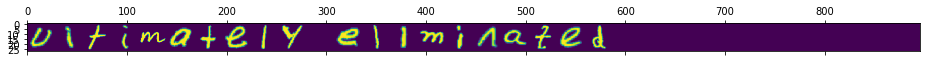

In [54]:
max_length = 32
generator = SentenceGenerator(max_length)
sample_string = generator.generate()
print(sample_string)
sample_image = construct_image_from_string(sample_string, samples_by_char_train, overlap=0)
print(sample_image.shape)
plt.matshow(sample_image)

(28, 617)


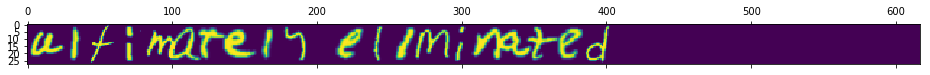

In [57]:
sample_image = construct_image_from_string(sample_string, samples_by_char_train, overlap=0.33)
print(sample_image.shape)
plt.matshow(sample_image)

Let's figure out how to reshape the image such that we only get a single letter.

In [ ]:
image_height, image_width = sample_image.shape
print(sample_image.shape)
image_reshaped = sample_image.reshape((image_height, max_length, image_width // max_length, 1))
print(image_reshaped.shape)
image_transposed = np.transpose(image_reshaped, (1, 0, 2, 3))
print(image_transposed.shape)
plt.matshow(image_transposed[0, :, :, 0])

In [58]:
# Create a small dataset of such images
def create_dataset_of_images(N, samples_by_char, sentence_generator, overlap):
    sample_label = sentence_generator.generate()
    sample_image = construct_image_from_string(sample_string, samples_by_char, overlap)
    images = np.zeros((N, sample_image.shape[0], sample_image.shape[1]), 'float32')
    labels = []
    for n in range(N):
        label = sentence_generator.generate()
        images[n] = construct_image_from_string(label, samples_by_char, overlap)
        labels.append(label)
    return images, labels
    
def convert_strings_to_categorical_labels(labels, mapping):
    return np.array([
        to_categorical([mapping[c] for c in label], num_classes=len(mapping))
        for label in labels
    ])

def create_dataset(num_train, num_test, overlap, sentence_generator):
    images_train, labels_train = create_dataset_of_images(num_train, samples_by_char_train, sentence_generator, overlap)
    labels_train_categorical = convert_strings_to_categorical_labels(labels_train, inverse_mapping)

    images_test, labels_test = create_dataset_of_images(num_test, samples_by_char_test, sentence_generator, overlap)
    labels_test_categorical = convert_strings_to_categorical_labels(labels_test, inverse_mapping)

    print('Train', images_train.shape, labels_train_categorical.shape)
    print('Test', images_test.shape, labels_test_categorical.shape)
    
    return images_train, labels_train_categorical, images_test, labels_test_categorical

In [59]:
num_train = 10000
num_test = 1000
overlap = 0
max_length = 32
sentence_generator = SentenceGenerator(max_length)

images_train, labels_train_categorical, images_test, labels_test_categorical = create_dataset(num_train, num_test, overlap, sentence_generator)

Train (10000, 28, 896) (10000, 32, 65)
Test (1000, 28, 896) (1000, 32, 65)


In [ ]:
print(f'images_train is {images_train.nbytes / 1e6} mb')

In [ ]:
def create_lenet(image_height: int, image_width: int) -> Model:
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(image_height, image_width, 1)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    return model

## TODO: before TimeDistributing LeNet, should just do LeNet over the whole image and see what happens.

def create_fixed_width_image_model(image_height: int, image_width: int, max_length: int, num_classes: int) -> Model:
    input_shape = (image_height, image_width)
    output_shape = (num_classes, max_length)
    image_input = Input(shape=input_shape)
    window_width = image_width // max_length
    image_patches = Reshape((image_height, max_length, window_width, 1))(image_input)
    image_patches_permuted = Permute((2, 1, 3, 4))(image_patches)    
    convnet = create_lenet(image_height, window_width)
    output = TimeDistributed(convnet)(image_patches_permuted)
    model = Model(inputs=image_input, outputs=output)
    model.summary()
    return model

def custom_loss(target, output):
    """This is actually just categorical_crossentropy still."""
    output /= tf.reduce_sum(output, -1, True)
    _epsilon = tf.convert_to_tensor(K.epsilon(), output.dtype.base_dtype)
    output = tf.clip_by_value(output, _epsilon, 1. - _epsilon)
    loss = - tf.reduce_sum(target * tf.log(output), -1)
    return loss

In [ ]:
image_height, image_width = images_train[0].shape
model = create_fixed_width_image_model(image_height, image_width, max_length, num_classes)
train_model(images_train, labels_train_categorical, epochs, batch_size, loss=custom_loss)

'and thc  plt hamhaiep wow een_t_'

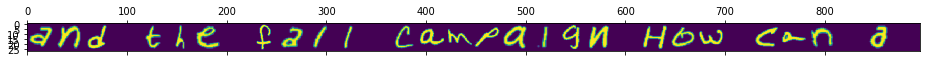

In [68]:
def convert_preds_to_string(preds):
    return ''.join(mapping[label] for label in np.argmax(preds, axis=-1).flatten()).strip()

plt.matshow(images_test[0])
convert_preds_to_string(model.predict(np.expand_dims(images_test[0], 0)))

In [1]:
# TODO: the accuracy is so high because it's easy to correctly classify blank spaces
# Should have custom loss function where blank space doesn't count -- or use masking (but keras makes that hard or impossible)

# OR: just use character accuracy as a metric, and stick with crossentropy loss

### Now let's try adding fully connected at the top

In [62]:
def create_lenet_without_softmax(image_height: int, image_width: int) -> Model:
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(image_height, image_width, 1)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    return model


def create_fixed_width_image_model_with_fc(image_height: int, image_width: int, max_length: int, num_classes: int) -> Model:
    input_shape = (image_height, image_width)
    # output_shape = (num_classes, max_length)

    image_input = Input(shape=input_shape) # (image_height, image_width)
    window_width = image_width // max_length 
    image_patches = Reshape((image_height, max_length, window_width, 1))(image_input)
    image_patches_permuted = Permute((2, 1, 3, 4))(image_patches)  # (max_length, image_height, window_width, 1)
    convnet = create_lenet_without_softmax(image_height, window_width)
    convnet_outputs = TimeDistributed(convnet)(image_patches_permuted)  # (max_length, 128) 
    convnet_outputs_flat = Flatten()(convnet_outputs) # (max_length * 128)
    fc = Dense(max_length * 128, activation='relu')(convnet_outputs_flat) # (max_length * 128)
    fc_reshaped = Reshape((max_length, 128))(fc)
    
    output = TimeDistributed(Dense(num_classes, activation='softmax'))(fc_reshaped)
    model = Model(inputs=image_input, outputs=output)
    model.summary()
    return model 

In [ ]:
image_height, image_width = sample_image.shape
model = create_fixed_width_image_model_with_fc(image_height, image_width, max_length, num_classes)
train_model(images_train, labels_train_categorical, epochs, batch_size)

In [ ]:
plt.matshow(sample_image)
convert_preds_to_string(model.predict(np.expand_dims(sample_image, 0)))

In [ ]:
## TODO: now get ready for production-type use, where you will have to give predictions on one image at a time
# We have to abstract the loading and preprocessing code so that it's the same between training use and test use
# At the end of this module, you will submit your code and model to Gradescope and it will be auto-graded on how accurate the model is.

### Now that we have the fully-connected layer, we can look at non-letter-sized windows

We want to achieve two things:
- be able to evaluate overlapping slices of the image
- decouple the number of slices we want to look at in the image from the width of the image

To achieve both these things, we will implement a sliding window with a stride.

- https://fomoro.com/tools/receptive-fields/#12,8,1,SAME

In [2]:
## Lesson: understanding how tf.extract_image_patches works
# How to debug and plot stuff inside tensorflow session

image = sample_image

sess = tf.InteractiveSession()
image_height, image_width = image.shape

print(image.shape)

image_tf = tf.expand_dims(tf.expand_dims(image, 0), -1)
print(sess.run(tf.shape(image_tf)))

window_width = 12
window_stride = 8
kernel = [1, 1, window_width, 1]
strides = [1, 1, window_stride, 1]
image_patches = tf.extract_image_patches(image_tf, kernel, strides, [1, 1, 1, 1], 'SAME')
print(sess.run(tf.shape(image_patches)))

for ind in range(3):
    patch = image_patches[0, :, ind, :]
    patch = tf.reshape(patch, [image_height, window_width])
    plt.matshow(sess.run(patch))

sess.close()

NameError: name 'sample_image' is not defined

In [63]:
def create_fixed_width_image_model_with_fc_and_sliding_window(image_height: int, image_width: int, max_length: int, num_classes: int) -> Model:
    input_shape = (image_height, image_width)
    # output_shape = (num_classes, max_length)

    image_input = Input(shape=input_shape) # (image_height, image_width)
    window_width = 12
    window_stride = 8
    
    def slide_window(image, window_width=window_width, window_stride=window_stride):
        # TODO: this can be an exercise
        import tensorflow as tf
        batch_size, image_height, image_width, num_channels = image.shape
        kernel = [1, 1, window_width, 1]
        strides = [1, 1, window_stride, 1]
        patches = tf.extract_image_patches(image, kernel, strides, [1, 1, 1, 1], 'SAME')
        patches = K.permute_dimensions(patches, (0, 2, 1, 3))
        patches = K.expand_dims(patches, axis=-1)
        return patches
    
    image_reshaped = Reshape((image_height, image_width, 1))(image_input)
    image_patches = Lambda(slide_window)(image_reshaped)  # (num_windows, num_windows, window_width, 1)
    convnet = create_lenet_without_softmax(image_height, window_width)
    convnet_outputs = TimeDistributed(convnet)(image_patches)  # (num_windows, 128) 
    convnet_outputs_flat = Flatten()(convnet_outputs) # (num_windows * 128)

    fc = Dense(max_length * 128, activation='relu')(convnet_outputs_flat) # (max_length * 128)
    fc_reshaped = Reshape((max_length, 128))(fc) # (max_length, 128)
    
    output = TimeDistributed(Dense(num_classes, activation='softmax'))(fc_reshaped) # (max_length, num_classes)
    model = Model(inputs=image_input, outputs=output)
    model.summary()
    return model

In [65]:
image_height, image_width = images_train[0].shape
model = create_fixed_width_image_model_with_fc_and_sliding_window(image_height, image_width, max_length, num_classes)
train_model(images_train, labels_train_categorical, epochs, batch_size)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 28, 896)           0         
_________________________________________________________________
reshape_4 (Reshape)          (None, 28, 896, 1)        0         
_________________________________________________________________
lambda_3 (Lambda)            (None, 112, 28, 12, 1)    0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, 112, 128)          412160    
_________________________________________________________________
flatten_4 (Flatten)          (None, 14336)             0         
_________________________________________________________________
dense_38 (Dense)             (None, 4096)              58724352  
_________________________________________________________________
reshape_5 (Reshape)          (None, 32, 128)           0         
__________

NameError: name 'convert_preds_to_string' is not defined

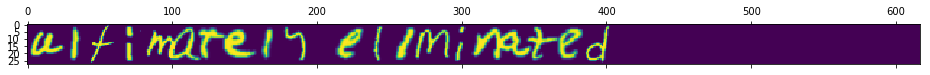

In [66]:
plt.matshow(sample_image)
convert_preds_to_string(model.predict(np.expand_dims(sample_image, 0)))

### Now we can deal with overlapping letters

In [ ]:
num_train = 50000
num_test = 5000
overlap = 0.33
max_length = 32
sentence_generator = SentenceGenerator(max_length)

images_train, labels_train_categorical, images_test, labels_test_categorical = create_dataset(num_train, num_test, overlap, sentence_generator)

In [ ]:
plt.matshow(images_train[2])

In [ ]:
sample_image = construct_image_from_string(random_string(string_length, max_length), samples_by_char_train, overlap)
image_height, image_width = sample_image.shape
model = create_fixed_width_image_model_with_fc_and_sliding_window(image_height, image_width, max_length, num_classes)
train_model(images_train, labels_train_categorical, epochs, batch_size)

In [ ]:
plt.matshow(images_test[1])
convert_preds_to_string(model.predict(np.expand_dims(images_test[1], 0)))

## Detect lines in a multi-line image

## Add parallel model search

## Add RNN to network

## Try on real handwriting data (IAM)

- Augment training data a lot (variable scale, variable skew, variable overlap)

## Add attention

## Deploy as a web service

## Deploy in another way

Either on AWS Lambda, or Kubernetes, or mobile.